## **Set up**

In [1]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=de5d1c268173c756f5e329a1afc9c4d61458cdcb4bb288db3bb1ffcdbd4ebbc4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def fix_apostrophes(text):
    return text.replace('apos', "'")

def prepare_input(sentences):
    return ". ".join(sentences)

def clean_summary(summary):
    # Remove repetitive endings and weird characters
    words = summary.split()
    cleaned_words = []
    for word in words:
        if len(word) > 1 or word.lower() in ['a', 'i']:  # Keep only meaningful words
            if len(cleaned_words) < 2 or word != cleaned_words[-1] or word != cleaned_words[-2]:
                cleaned_words.append(word)
    return ' '.join(cleaned_words).strip()

In [4]:
url = "https://raw.githubusercontent.com/zhangke626/w266_project/main/training_data_with_objectivity.csv"
df = pd.read_csv(url)

url = "https://raw.githubusercontent.com/zhangke626/w266_project/main/initial_data.csv"
df_article = pd.read_csv(url)

objective_sentences = df[df['objectivity_score'] == 1].copy()
# Fix apostrophes in individual sentences
objective_sentences.loc[:, 'sentence'] = objective_sentences['sentence'].apply(fix_apostrophes)

# Now proceed with grouping and creating input_text
grouped_sentences = objective_sentences.groupby('title')['sentence'].apply(list).reset_index()

grouped_sentences['input_text'] = grouped_sentences['sentence'].apply(prepare_input)

# Merge with df_article
grouped_sentences = grouped_sentences.merge(df_article[['title', 'article', 'publication', 'section', 'url']], on='title', how='left')

In [5]:
df_article_titles = set(df_article['title'])
grouped_sentences_titles = set(grouped_sentences['title'])

missing_titles = df_article_titles - grouped_sentences_titles

print(f"Number of missing titles: {len(missing_titles)}")
print("Missing titles:")
for title in missing_titles:
    print(title)

Number of missing titles: 3
Missing titles:
BIRTHDAY OF THE DAY: Sen. Michael Bennet (D-Colo.)
Should Democrats Fear Trump?
Tim Kaine's convention speech: 5 moments that made a splash on Twitter


In [6]:
grouped_sentences[grouped_sentences['title']=='Russia struggles with legacy of 1917 Bolshevik Revolution'].input_text

607    next image 1 of 2 prev image 2 of 2 moscow  th...
Name: input_text, dtype: object

In [7]:
sample_size = 10

random_seed = 42
random.seed(random_seed)

# Create an empty list to store the sampled DataFrames
sampled_dfs = []

for publication, group in grouped_sentences.groupby('publication'):
    sampled_group = group.sample(n=min(sample_size, len(group)), random_state=random_seed)
    sampled_dfs.append(sampled_group)

# Concatenate all the sampled DataFrames
test_df = pd.concat(sampled_dfs, ignore_index=True)

# Shuffle the final DataFrame to mix the publications
test_df = test_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

test_df.head()

,title,sentence,input_text,article,publication,section,url
0,John Bolton says he is prepared to testify in ...,[cnnformer white house national security advis...,cnnformer white house national security advise...,(CNN)Former White House national security adv...,CNN,politics,https://www.cnn.com/2020/01/06/politics/john-b...
1,Devin Nunes now says he talked to key Ukraine ...,[washington cnnthe top republican on the house...,washington cnnthe top republican on the house ...,Washington (CNN)The top Republican on the Hous...,CNN,politics,https://www.cnn.com/2020/01/16/politics/devin-...
2,India Markets Weekahead: RBI policy meet in focus,[markets gained on optimism over gst rate cuts...,markets gained on optimism over gst rate cuts ...,Markets gained on optimism over GST rate cuts ...,Reuters,Expert Zone,https://www.reuters.com/article/india-markets-...
3,Dozens of mourners killed in stampede at Solei...,[dozens of people have reportedly died in a st...,dozens of people have reportedly died in a sta...,Dozens of people have reportedly died in a sta...,The Hill,NaN,https://thehill.com/policy/international/middl...
4,Momentous days in Ethiopia as new PM pledges m...,[sweeping changes that seemed unthinkable just...,sweeping changes that seemed unthinkable just ...,"ADDIS ABABA, Ethiopia – These are not ordinar...",Fox News,World,https://www.foxnews.com/world/momentous-days-i...


articles missing due to very low length and not objective

## **Experimenting with Pegasus**

In [8]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def count_tokens(text):
    return len(tokenizer.encode(text))

# Calculate token counts for each article
grouped_sentences['token_count'] = grouped_sentences['input_text'].apply(count_tokens)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


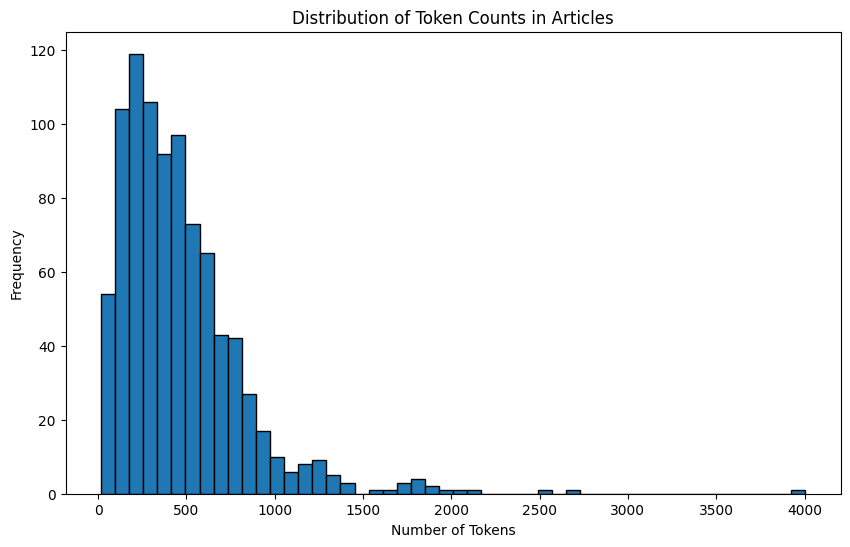


Percentiles of token counts:
10th percentile: 132
25th percentile: 221
50th percentile: 393
75th percentile: 601
90th percentile: 850
95th percentile: 1096
99th percentile: 1829


In [9]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(grouped_sentences['token_count'], bins=50, edgecolor='black')
plt.title('Distribution of Token Counts in Articles')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Print some percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles of token counts:")
for p in percentiles:
    print(f"{p}th percentile: {grouped_sentences['token_count'].quantile(p/100):.0f}")

In [10]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Truncate input if it's too long
        max_input_length = 1024
        input_ids = tokenizer(cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids.to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=400,
            min_length=100,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average ROUGE scores:
ROUGE-1: 0.3221
ROUGE-2: 0.2929
ROUGE-L: 0.3106


In [11]:
from google.colab import files
test_df.to_csv('test_pegasus_fixed.csv')
files.download('test_pegasus_fixed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Instead of using arbitrary length, let's find the actual max_length based on the data




In [12]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Count tokens in the input text
        input_token_count = len(tokenizer.encode(cleaned_text))

        # Set dynamic max_length and min_length
        max_length = min(int(input_token_count * 0.5),400)
        min_length = max(int(input_token_count * 0.25),100)

        # Ensure min_length is not greater than max_length
        min_length = min(min_length, max_length - 1)

        max_input_length = 1024
        input_ids = tokenizer(cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids.to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=min_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (1252 > 1024). Running this sequence through the model will result in indexing errors


Average ROUGE scores:
ROUGE-1: 0.2578
ROUGE-2: 0.2416
ROUGE-L: 0.2551


In [13]:
from google.colab import files
test_df.to_csv('test_pegasus_var.csv')
files.download('test_pegasus_var.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Expirimenting with T5**

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

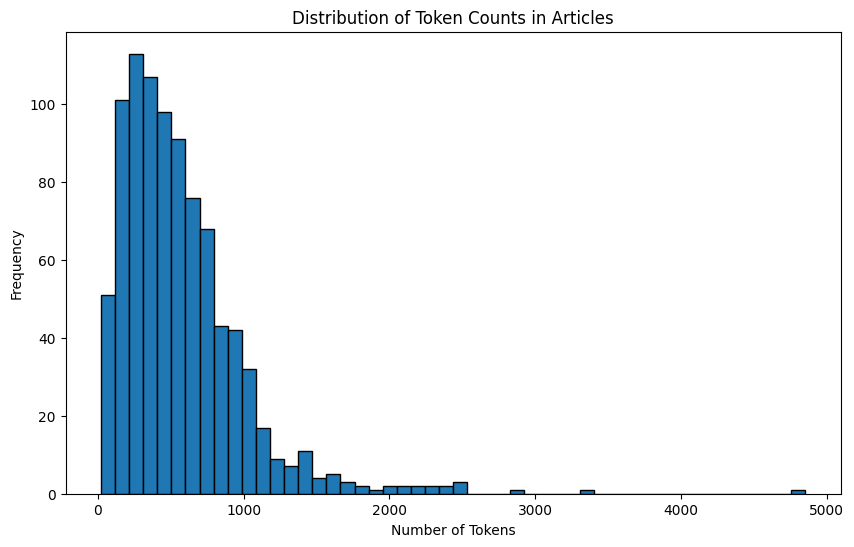


Percentiles of token counts:
10th percentile: 163
25th percentile: 274
50th percentile: 483
75th percentile: 754
90th percentile: 1039
95th percentile: 1329
99th percentile: 2252


In [14]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def count_tokens(text):
    return len(tokenizer.encode(text))

# Calculate token counts for each article
grouped_sentences['token_count'] = grouped_sentences['input_text'].apply(count_tokens)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(grouped_sentences['token_count'], bins=50, edgecolor='black')
plt.title('Distribution of Token Counts in Articles')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Print some percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles of token counts:")
for p in percentiles:
    print(f"{p}th percentile: {grouped_sentences['token_count'].quantile(p/100):.0f}")

In [15]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        max_input_length = 2048
        input_ids = tokenizer.encode("summarize: " + cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=400,
            min_length=100,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Average ROUGE scores:
ROUGE-1: 0.2500
ROUGE-2: 0.2171
ROUGE-L: 0.2397


In [16]:
from google.colab import files
test_df.to_csv('test_t5_fixed.csv')
files.download('test_t5_fixed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Experimenting with length

In [17]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Count tokens in the input text
        input_token_count = len(tokenizer.encode(cleaned_text))

        # Set dynamic max_length and min_length
        max_length = min(int(input_token_count * 0.5),400)
        min_length = min(int(input_token_count * 0.25),100)

        # Ensure min_length is not greater than max_length
        min_length = min(min_length, max_length - 1)

        max_input_length = 2048
        input_ids = tokenizer.encode("summarize: " + cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=min_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Average ROUGE scores:
ROUGE-1: 0.2261
ROUGE-2: 0.2023
ROUGE-L: 0.2218


In [18]:
from google.colab import files
test_df.to_csv('test_t5_var.csv')
files.download('test_t5_var.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Rouge Analysis**

In [55]:
df_t5_var = pd.read_csv('test_t5_var.csv')
df_t5_fixed  = pd.read_csv('test_t5_fixed.csv')
df_pegasus_var  = pd.read_csv('test_pegasus_var.csv')
df_pegasus_fixed  = pd.read_csv('test_pegasus_fixed.csv')

In [56]:
# Extract relevant columns and rename them for clarity
df_t5_var = df_t5_var[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                       'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]
df_pegasus_fixed = df_pegasus_fixed[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                                     'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]
df_t5_fixed = df_t5_fixed[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                           'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]
df_pegasus_var = df_pegasus_var[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                                 'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]

# Rename columns to include model information
df_t5_var.columns = ['title', 'input_text', 'summary_t5_var', 'rouge1_precision_t5_var', 'rouge1_recall_t5_var', 'rouge1_f1_t5_var',
                     'rouge2_precision_t5_var', 'rouge2_recall_t5_var', 'rouge2_f1_t5_var', 'rougeL_precision_t5_var', 'rougeL_recall_t5_var', 'rougeL_f1_t5_var']
df_pegasus_fixed.columns = ['title', 'input_text', 'summary_pegasus_fixed', 'rouge1_precision_pegasus_fixed', 'rouge1_recall_pegasus_fixed', 'rouge1_f1_pegasus_fixed',
                            'rouge2_precision_pegasus_fixed', 'rouge2_recall_pegasus_fixed', 'rouge2_f1_pegasus_fixed', 'rougeL_precision_pegasus_fixed', 'rougeL_recall_pegasus_fixed', 'rougeL_f1_pegasus_fixed']
df_t5_fixed.columns = ['title', 'input_text', 'summary_t5_fixed', 'rouge1_precision_t5_fixed', 'rouge1_recall_t5_fixed', 'rouge1_f1_t5_fixed',
                       'rouge2_precision_t5_fixed', 'rouge2_recall_t5_fixed', 'rouge2_f1_t5_fixed', 'rougeL_precision_t5_fixed', 'rougeL_recall_t5_fixed', 'rougeL_f1_t5_fixed']
df_pegasus_var.columns = ['title', 'input_text', 'summary_pegasus_var', 'rouge1_precision_pegasus_var', 'rouge1_recall_pegasus_var', 'rouge1_f1_pegasus_var',
                          'rouge2_precision_pegasus_var', 'rouge2_recall_pegasus_var', 'rouge2_f1_pegasus_var', 'rougeL_precision_pegasus_var', 'rougeL_recall_pegasus_var', 'rougeL_f1_pegasus_var']

# Merge dataframes on 'title' and 'input_text'
df_merged = df_t5_var.merge(df_pegasus_fixed, on=['title', 'input_text']).merge(df_t5_fixed, on=['title', 'input_text']).merge(df_pegasus_var, on=['title', 'input_text'])

# Optionally, display the merged dataframe
df_merged.head()

,title,input_text,summary_t5_var,rouge1_precision_t5_var,rouge1_recall_t5_var,rouge1_f1_t5_var,rouge2_precision_t5_var,rouge2_recall_t5_var,rouge2_f1_t5_var,rougeL_precision_t5_var,...,summary_pegasus_var,rouge1_precision_pegasus_var,rouge1_recall_pegasus_var,rouge1_f1_pegasus_var,rouge2_precision_pegasus_var,rouge2_recall_pegasus_var,rouge2_f1_pegasus_var,rougeL_precision_pegasus_var,rougeL_recall_pegasus_var,rougeL_f1_pegasus_var
0,John Bolton says he is prepared to testify in ...,cnnformer white house national security advise...,former white house national security adviser j...,1.000000,0.043025,0.082500,0.953846,0.040444,0.077597,1.000000,...,cnnformer white house national security advise...,0.989899,0.063885,0.120024,0.959184,0.061318,0.115267,0.989899,0.063885,0.120024
1,Devin Nunes now says he talked to key Ukraine ...,washington cnnthe top republican on the house ...,devin nunes admitted wednesday to speaking on ...,0.986667,0.108824,0.196026,0.918919,0.100147,0.180611,0.960000,...,last month democrats released phone records as...,1.000000,0.139706,0.245161,0.968085,0.134021,0.235446,1.000000,0.139706,0.245161
2,India Markets Weekahead: RBI policy meet in focus,markets gained on optimism over gst rate cuts ...,markets gained on optimism over gst rate cuts ...,0.972973,0.091720,0.167637,0.863014,0.080357,0.147025,0.959459,...,twowheeler stocks were in focus after bajaj au...,0.956522,0.112102,0.200684,0.824176,0.095663,0.171429,0.858696,0.100637,0.180160
3,Dozens of mourners killed in stampede at Solei...,dozens of people have reportedly died in a sta...,dozens of people have reportedly died in a sta...,0.955882,0.151869,0.262097,0.895522,0.140515,0.242915,0.955882,...,dozens of people have reportedly died in a sta...,0.972222,0.163551,0.280000,0.915493,0.152225,0.261044,0.972222,0.163551,0.280000
4,Momentous days in Ethiopia as new PM pledges m...,sweeping changes that seemed unthinkable just ...,sweeping changes that seem unthinkable just we...,0.987013,0.085011,0.156540,0.907895,0.077268,0.142415,0.987013,...,sweeping changes that seemed unthinkable just ...,0.990476,0.116331,0.208208,0.942308,0.109742,0.196590,0.980952,0.115213,0.206206


In [57]:
# Calculate mean statistics for the ROUGE metrics
rouge_metrics = ['rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                 'rouge2_precision', 'rouge2_recall', 'rouge2_f1',
                 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']

models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var']

mean_stats = df_merged[[f'{metric}_{model}' for metric in rouge_metrics for model in models]].mean()

# Restructure mean_stats into a table form
mean_stats_df = mean_stats.reset_index()
mean_stats_df.columns = ['metric_model', 'mean_value']

# Split the metric_model column into separate columns for metric, model, and type
mean_stats_df[['metric', 'type', 'model']] = mean_stats_df['metric_model'].str.extract(r'(rouge[0-9L])_(precision|recall|f1)_(.+)')
mean_stats_df = mean_stats_df.drop(columns=['metric_model'])

# Pivot the table to have types as columns
mean_stats_pivot = mean_stats_df.pivot_table(index=['model', 'metric'], columns='type', values='mean_value').reset_index()

<ipython-input-58-3bea59d24c1c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


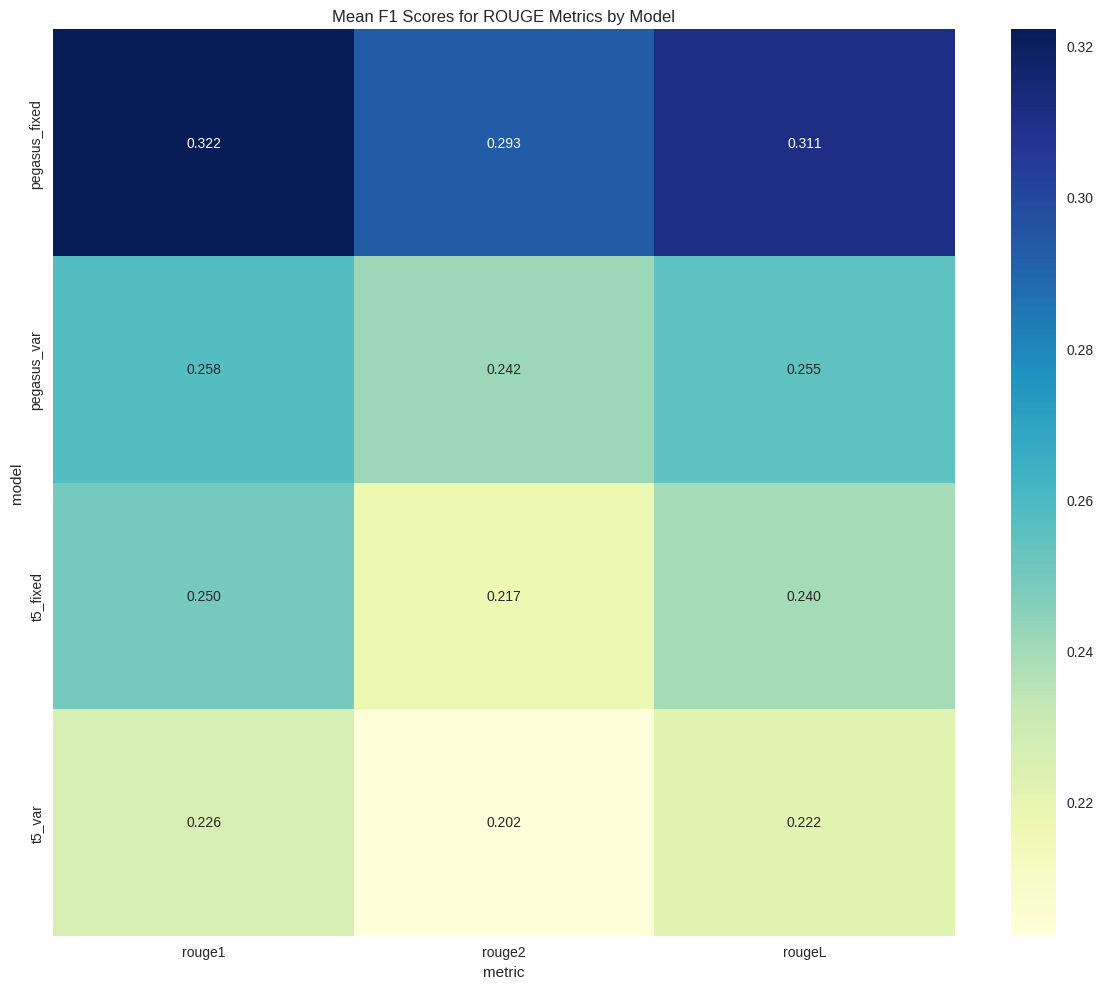

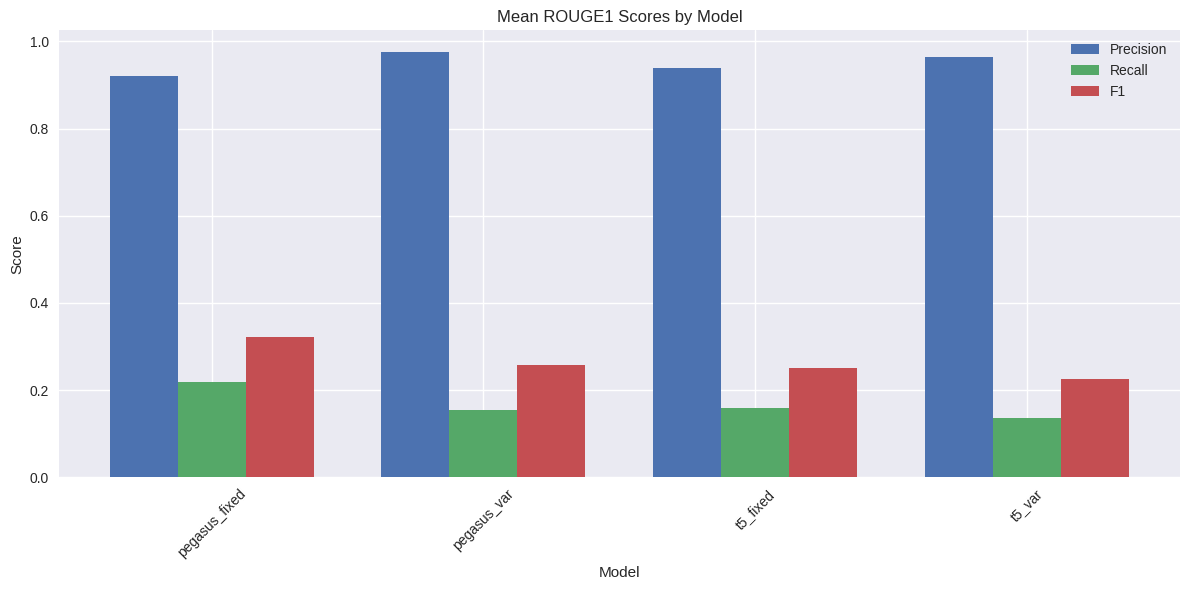

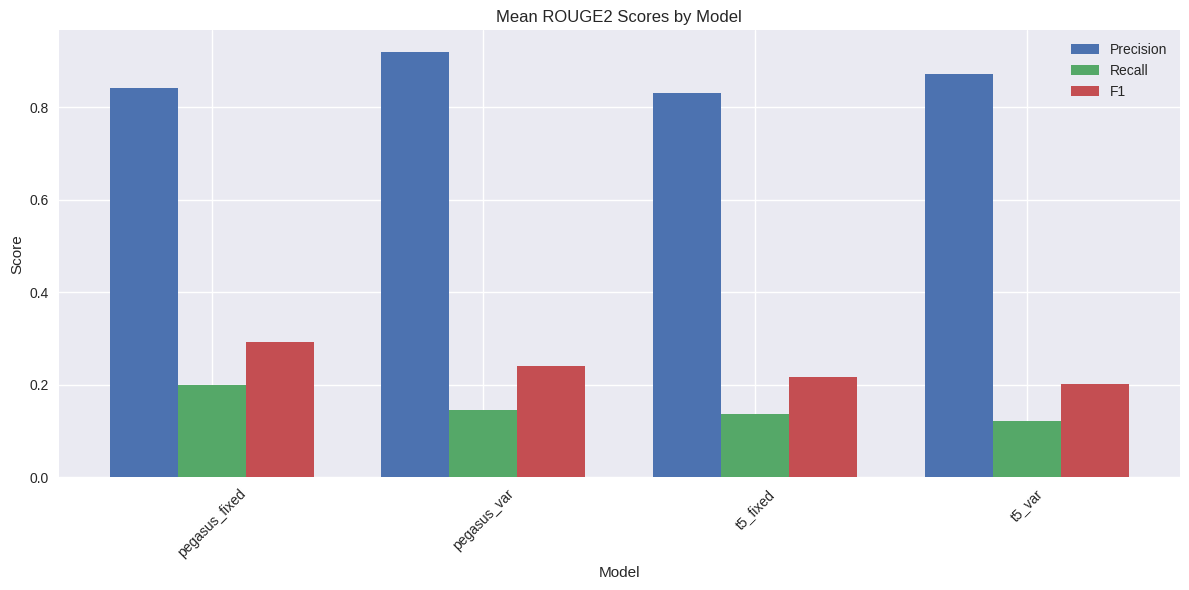

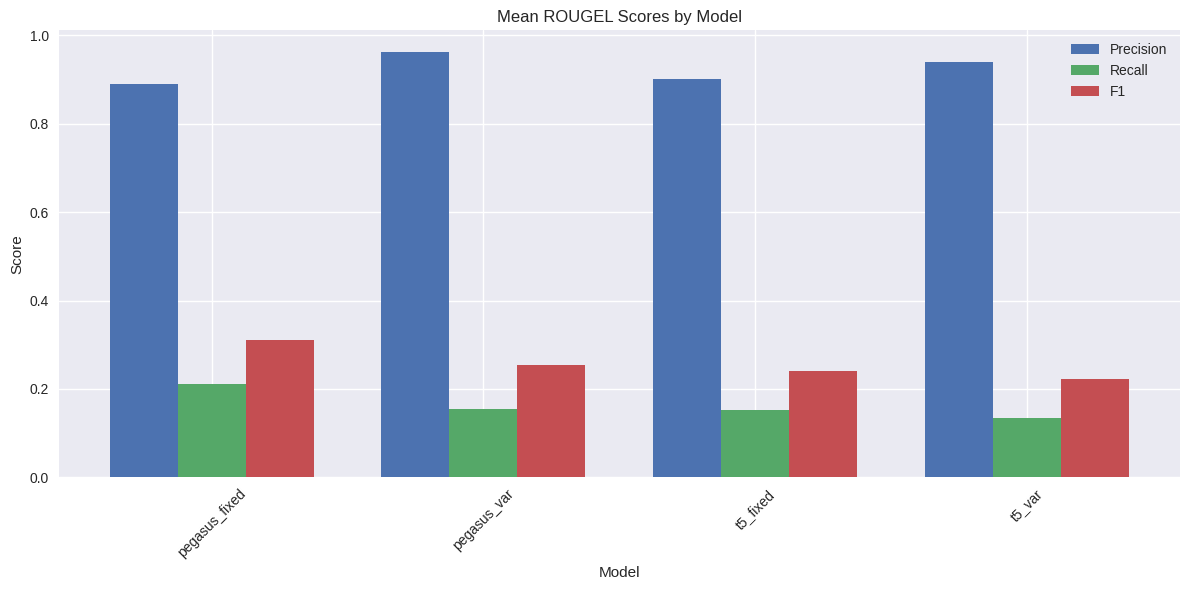

Best performing model based on average F1 scores: pegasus_fixed

Summary Statistics:
        model metric       f1  precision   recall
pegasus_fixed rouge1 0.322148   0.921527 0.219457
pegasus_fixed rouge2 0.292931   0.841841 0.198579
pegasus_fixed rougeL 0.310644   0.889357 0.210952
  pegasus_var rouge1 0.257782   0.976414 0.155058
  pegasus_var rouge2 0.241625   0.920236 0.145207
  pegasus_var rougeL 0.255127   0.963281 0.153548
     t5_fixed rouge1 0.249989   0.938935 0.159256
     t5_fixed rouge2 0.217114   0.830575 0.137595
     t5_fixed rougeL 0.239706   0.900413 0.152366
       t5_var rouge1 0.226124   0.964698 0.135972
       t5_var rouge2 0.202315   0.871946 0.121480
       t5_var rougeL 0.221769   0.940227 0.133465


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn')

# 1. Heatmap of mean ROUGE scores
plt.figure(figsize=(12, 10))
heatmap_data = mean_stats_pivot.pivot(index='model', columns='metric', values='f1')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Mean F1 Scores for ROUGE Metrics by Model')
plt.tight_layout()
plt.show()

# 2. Bar plot for each ROUGE metric
for metric in ['rouge1', 'rouge2', 'rougeL']:
    plt.figure(figsize=(12, 6))
    data = mean_stats_pivot[mean_stats_pivot['metric'] == metric]
    x = np.arange(len(data))
    width = 0.25

    plt.bar(x - width, data['precision'], width, label='Precision')
    plt.bar(x, data['recall'], width, label='Recall')
    plt.bar(x + width, data['f1'], width, label='F1')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(f'Mean {metric.upper()} Scores by Model')
    plt.xticks(x, data['model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Determine best model based on average F1 scores
best_model = mean_stats_pivot[mean_stats_pivot['metric'].isin(['rouge1', 'rouge2', 'rougeL'])].groupby('model')['f1'].mean().idxmax()
print(f"Best performing model based on average F1 scores: {best_model}")

# 5. Print summary statistics
print("\nSummary Statistics:")
print(mean_stats_pivot.to_string(index=False))

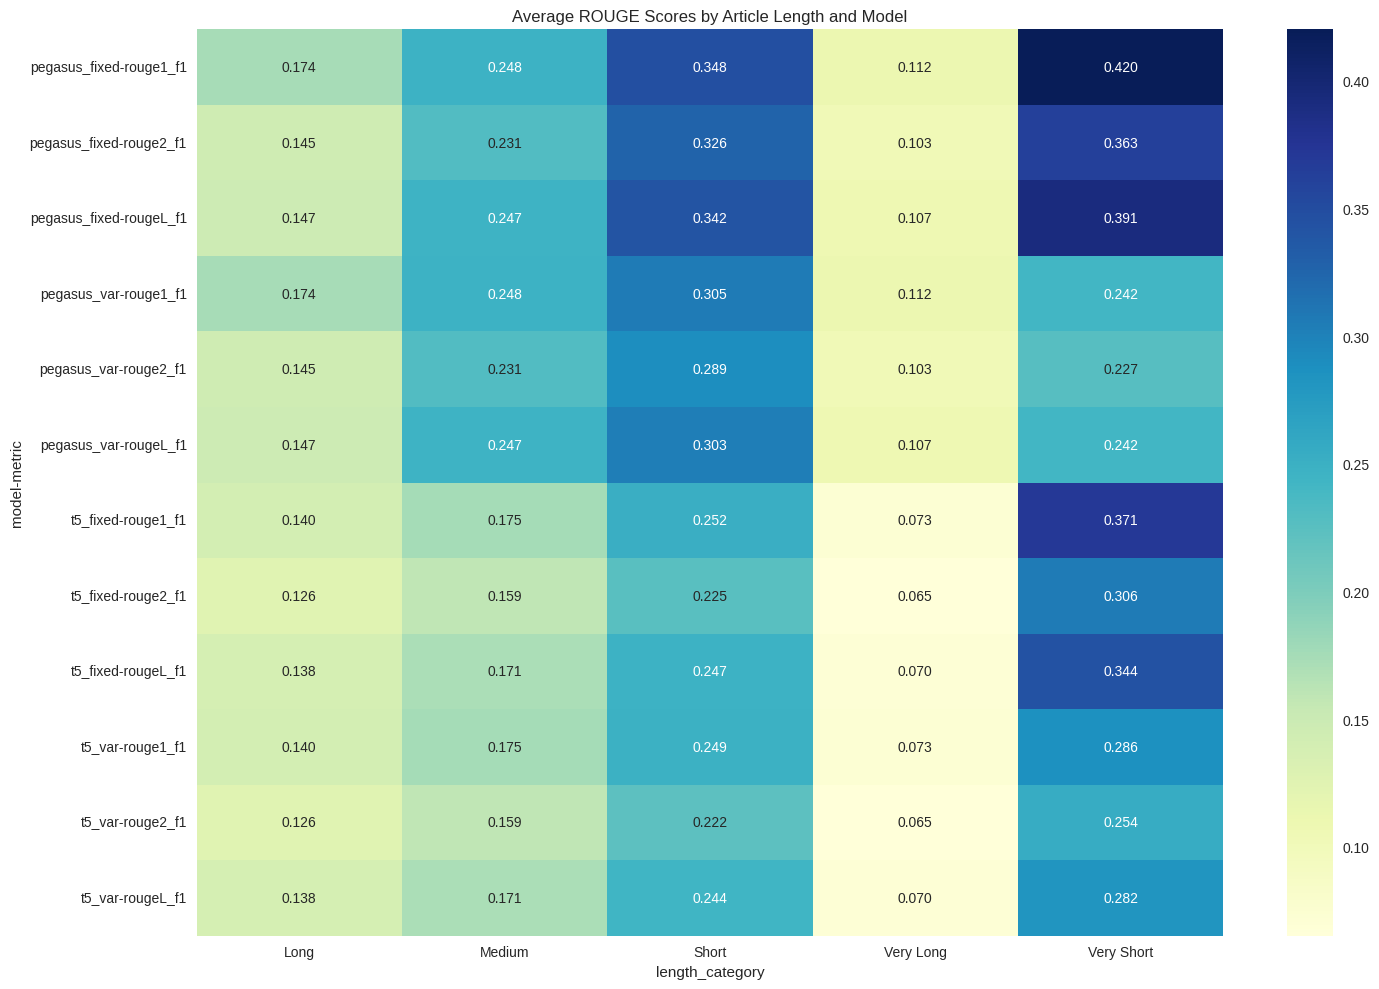

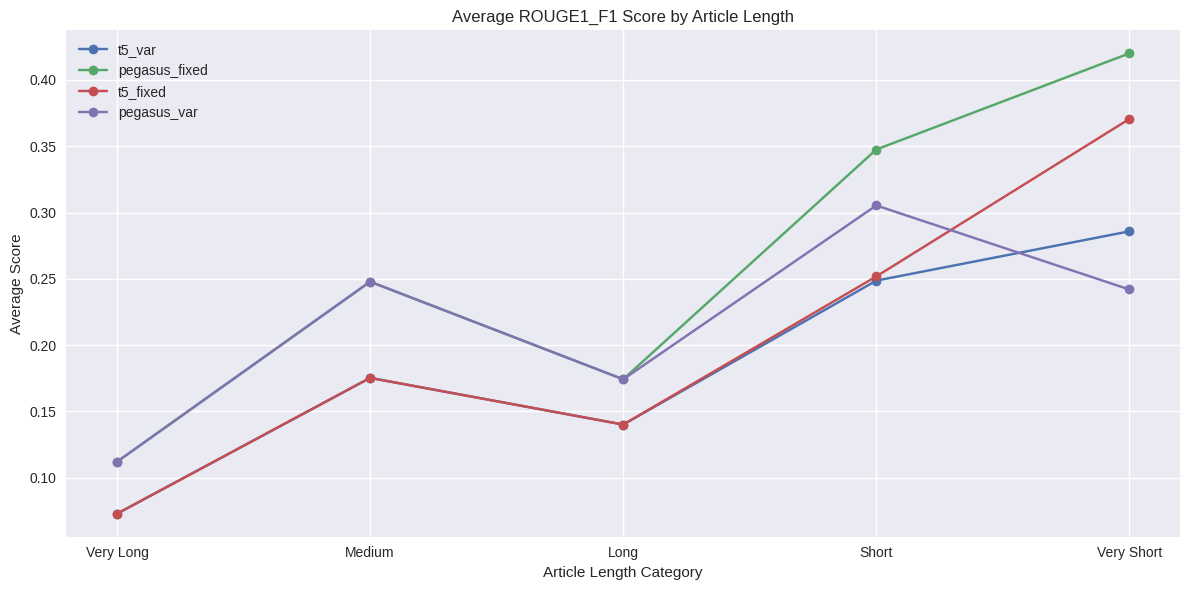

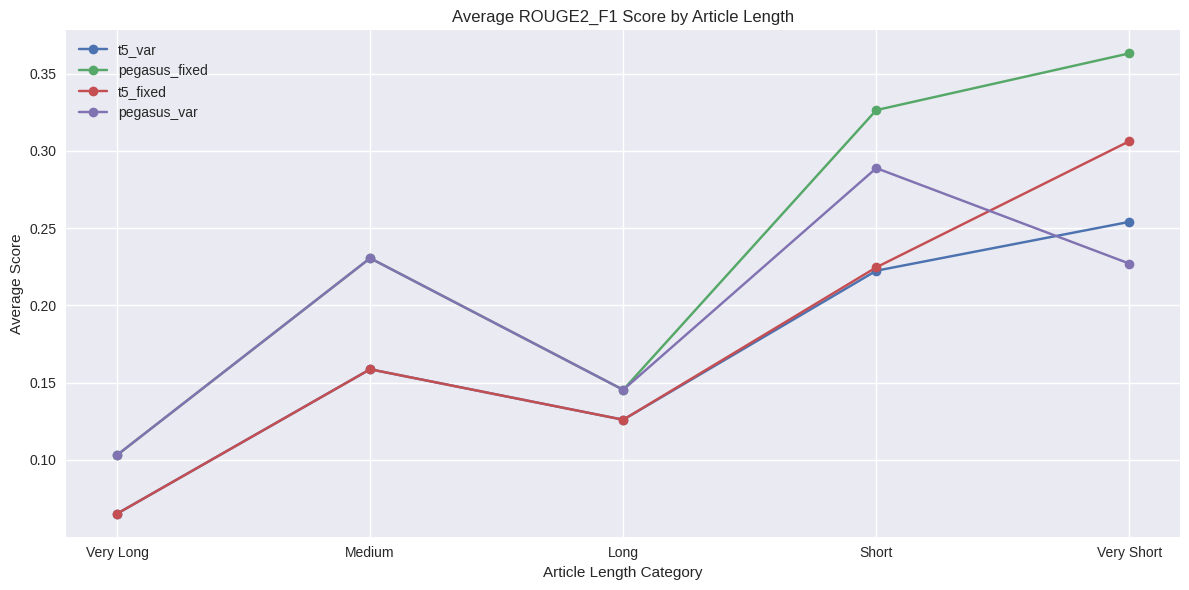

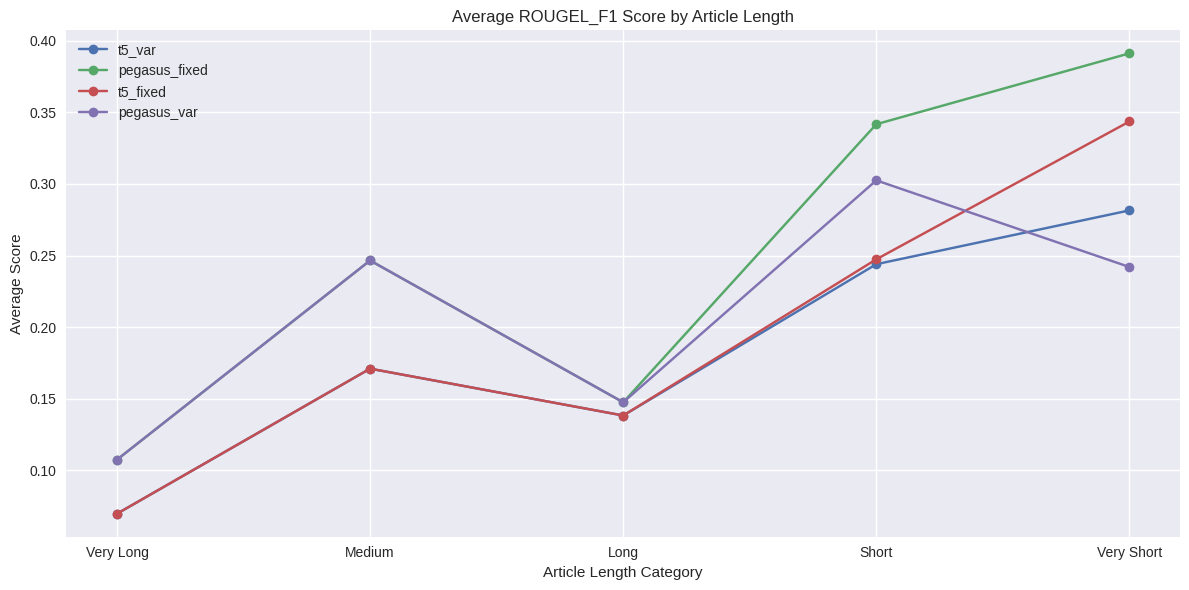

Average ROUGE Scores by Article Length Category:
length_category              Long    Medium     Short  Very Long  Very Short
model         metric                                                        
pegasus_fixed rouge1_f1  0.174249  0.247855  0.347547   0.112056    0.420066
              rouge2_f1  0.145382  0.230592  0.326414   0.103152    0.363143
              rougeL_f1  0.147395  0.246531  0.341763   0.107330    0.391298
pegasus_var   rouge1_f1  0.174249  0.247855  0.305362   0.112056    0.241972
              rouge2_f1  0.145382  0.230592  0.288867   0.103152    0.227062
              rougeL_f1  0.147395  0.246531  0.302522   0.107330    0.241972
t5_fixed      rouge1_f1  0.140102  0.175311  0.251821   0.072883    0.370598
              rouge2_f1  0.126022  0.158680  0.224650   0.065202    0.306306
              rougeL_f1  0.138167  0.170921  0.247346   0.069541    0.343667
t5_var        rouge1_f1  0.140102  0.175311  0.248666   0.072883    0.285837
              rouge2_f1  0.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate article lengths
df_merged['article_length'] = df_merged['input_text'].str.split().str.len()

# Define length categories
def categorize_length(length):
    if length < 200:
        return 'Very Short'
    elif length < 400:
        return 'Short'
    elif length < 600:
        return 'Medium'
    elif length < 800:
        return 'Long'
    else:
        return 'Very Long'

df_merged['length_category'] = df_merged['article_length'].apply(categorize_length)

# Calculate average ROUGE scores by length category and model
rouge_metrics = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']
models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var']

avg_scores = []

for model in models:
    for metric in rouge_metrics:
        for category in df_merged['length_category'].unique():
            avg_score = df_merged[df_merged['length_category'] == category][f'{metric}_{model}'].mean()
            avg_scores.append({
                'model': model,
                'metric': metric,
                'length_category': category,
                'avg_score': avg_score
            })

avg_scores_df = pd.DataFrame(avg_scores)

# Plot heatmap
plt.figure(figsize=(15, 10))
pivot_df = avg_scores_df.pivot_table(values='avg_score', index=['model', 'metric'], columns='length_category')
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Average ROUGE Scores by Article Length and Model')
plt.tight_layout()
plt.show()

# Plot line graphs
for metric in rouge_metrics:
    plt.figure(figsize=(12, 6))
    for model in models:
        data = avg_scores_df[(avg_scores_df['model'] == model) & (avg_scores_df['metric'] == metric)]
        plt.plot(data['length_category'], data['avg_score'], marker='o', label=model)

    plt.title(f'Average {metric.upper()} Score by Article Length')
    plt.xlabel('Article Length Category')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print summary statistics
print("Average ROUGE Scores by Article Length Category:")
print(pivot_df.to_string())

# Analyze best model for each length category
best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]
print("\nBest Performing Model by Length Category and Metric:")
print(best_models[['length_category', 'metric', 'model', 'avg_score']].to_string(index=False))

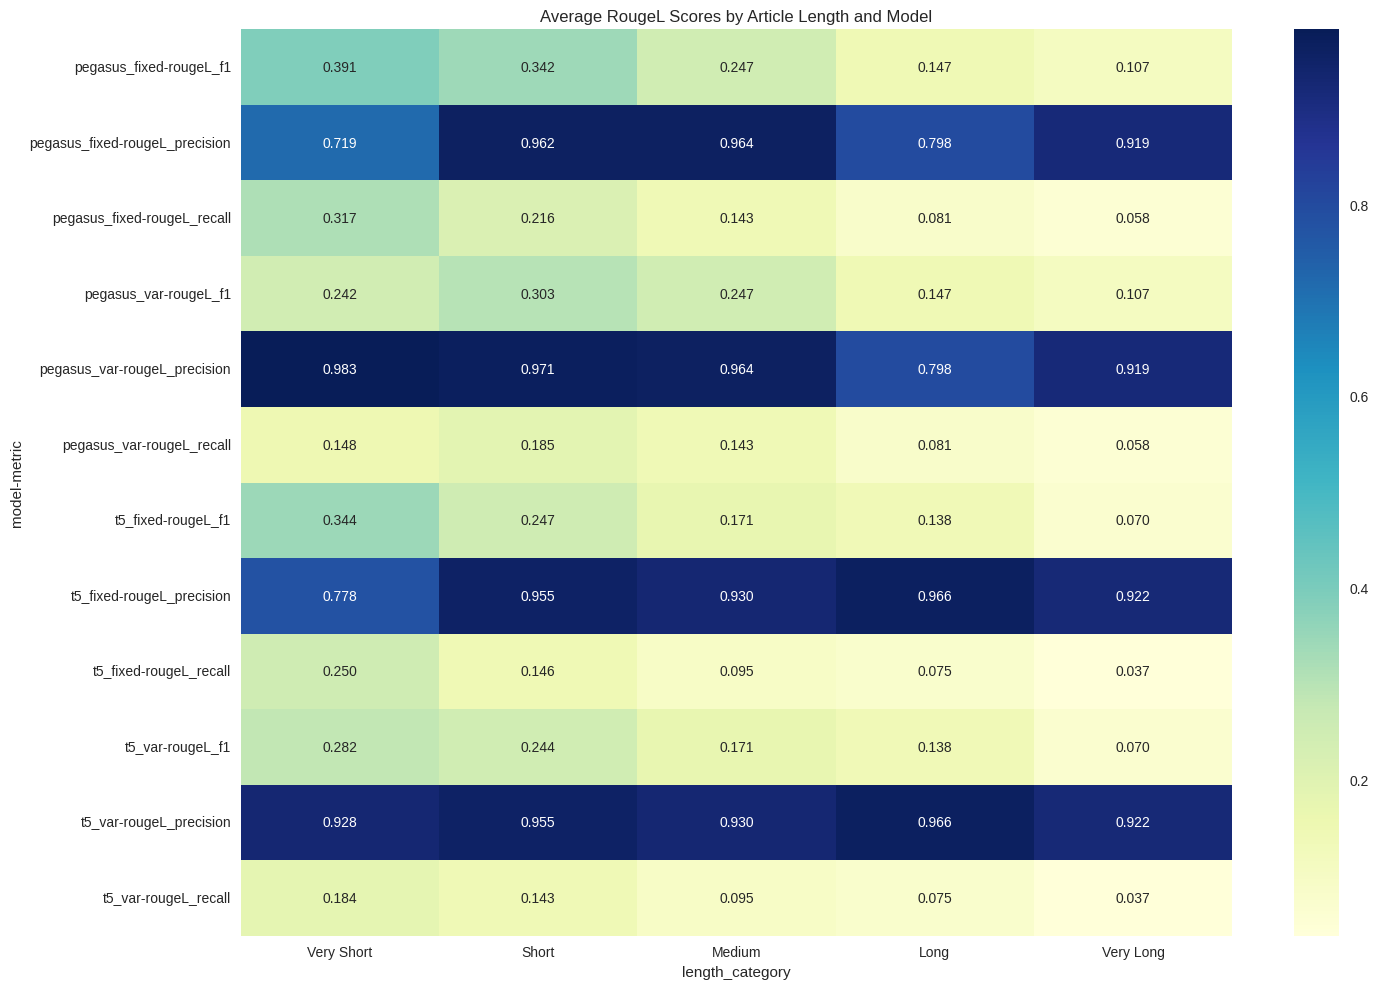

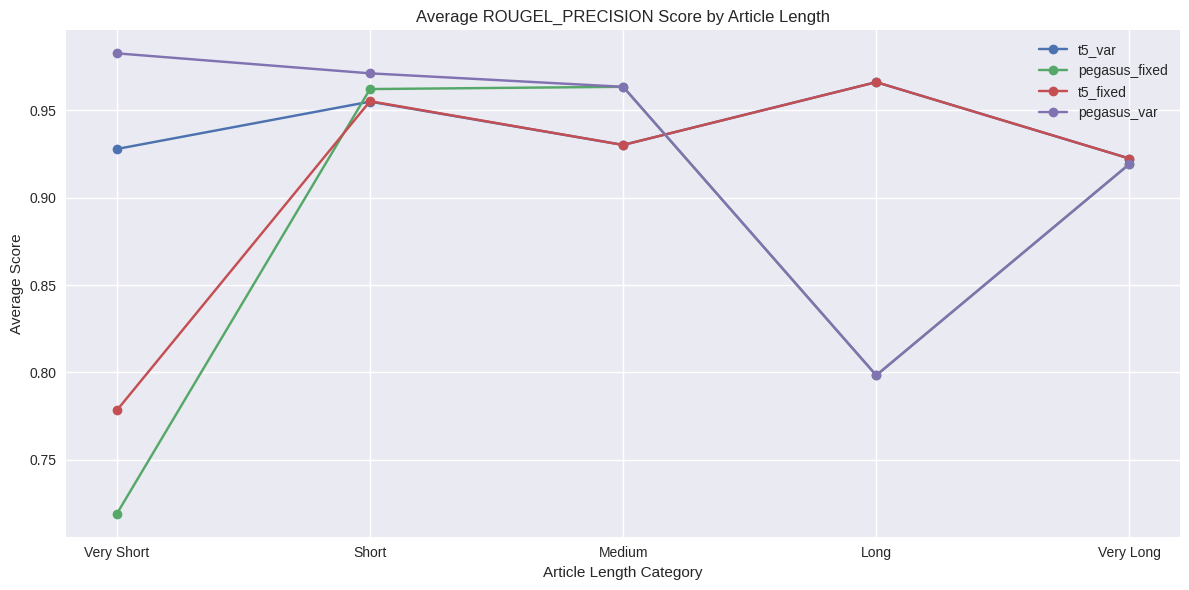

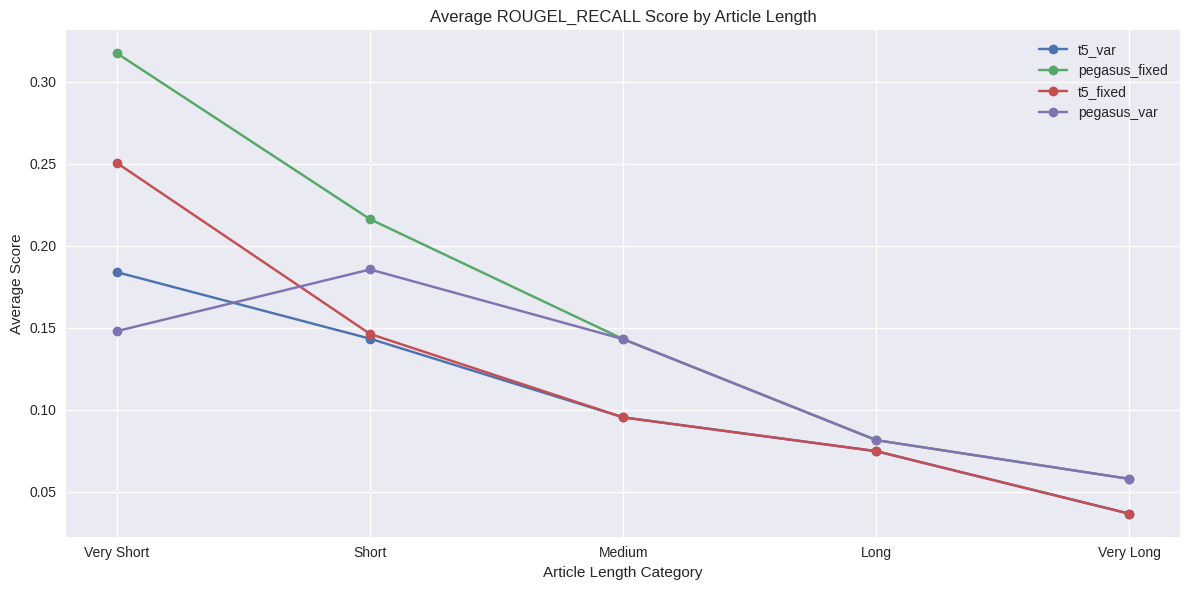

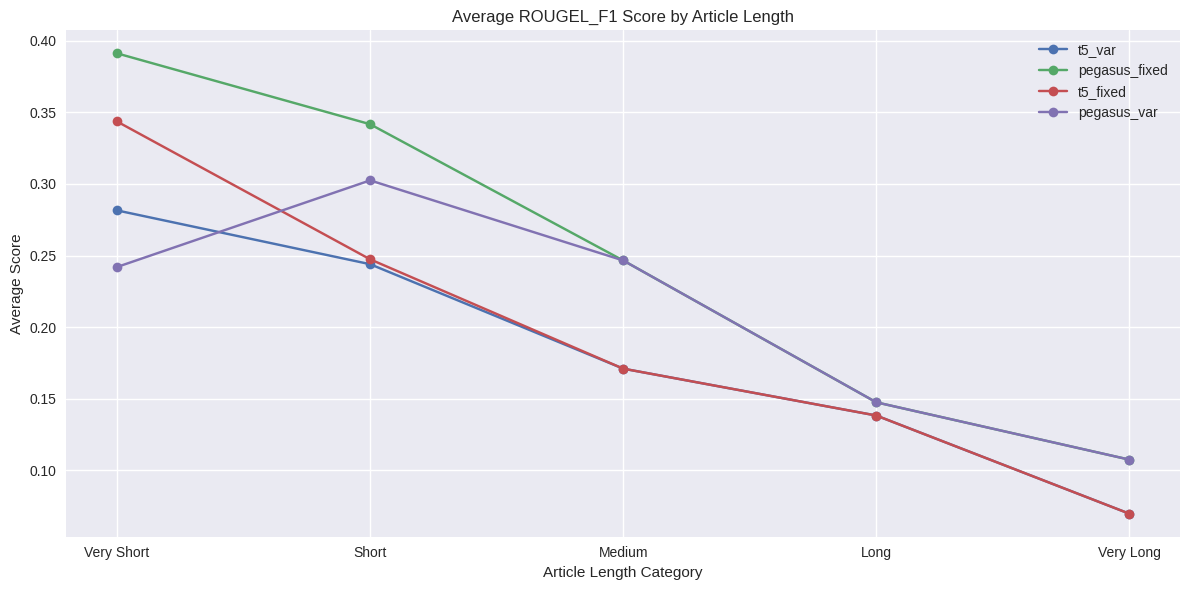

Average RougeL Scores by Article Length Category:
length_category                 Very Short     Short    Medium      Long  Very Long
model         metric                                                               
pegasus_fixed rougeL_f1           0.391298  0.341763  0.246531  0.147395   0.107330
              rougeL_precision    0.719006  0.962248  0.963543  0.798280   0.919295
              rougeL_recall       0.317241  0.216078  0.142971  0.081390   0.057758
pegasus_var   rougeL_f1           0.241972  0.302522  0.246531  0.147395   0.107330
              rougeL_precision    0.982706  0.971258  0.963543  0.798280   0.919295
              rougeL_recall       0.147901  0.185460  0.142971  0.081390   0.057758
t5_fixed      rougeL_f1           0.343667  0.247346  0.170921  0.138167   0.069541
              rougeL_precision    0.778261  0.955290  0.930240  0.966216   0.922461
              rougeL_recall       0.250344  0.146129  0.095277  0.074659   0.036537
t5_var        rougeL_f1   

<ipython-input-60-64f14485ad37>:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate article lengths
df_merged['article_length'] = df_merged['input_text'].str.split().str.len()

# Define length categories
def categorize_length(length):
    if length < 200:
        return 'Very Short'
    elif length < 400:
        return 'Short'
    elif length < 600:
        return 'Medium'
    elif length < 800:
        return 'Long'
    else:
        return 'Very Long'

df_merged['length_category'] = df_merged['article_length'].apply(categorize_length)

# Define the order of length categories
length_order = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']

# Calculate average RougeL scores by length category and model
rougeL_metrics = ['rougeL_precision', 'rougeL_recall', 'rougeL_f1']
models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var']

avg_scores = []

for model in models:
    for metric in rougeL_metrics:
        for category in length_order:
            avg_score = df_merged[df_merged['length_category'] == category][f'{metric}_{model}'].mean()
            avg_scores.append({
                'model': model,
                'metric': metric,
                'length_category': category,
                'avg_score': avg_score
            })

avg_scores_df = pd.DataFrame(avg_scores)

# Ensure the length categories are in the correct order
avg_scores_df['length_category'] = pd.Categorical(avg_scores_df['length_category'], categories=length_order, ordered=True)
avg_scores_df = avg_scores_df.sort_values('length_category')

# Plot heatmap
plt.figure(figsize=(15, 10))
pivot_df = avg_scores_df.pivot_table(values='avg_score', index=['model', 'metric'], columns='length_category')
pivot_df = pivot_df.reindex(columns=length_order)
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Average RougeL Scores by Article Length and Model')
plt.tight_layout()
plt.show()

# Plot line graphs
for metric in rougeL_metrics:
    plt.figure(figsize=(12, 6))
    for model in models:
        data = avg_scores_df[(avg_scores_df['model'] == model) & (avg_scores_df['metric'] == metric)]
        plt.plot(data['length_category'], data['avg_score'], marker='o', label=model)

    plt.title(f'Average {metric.upper()} Score by Article Length')
    plt.xlabel('Article Length Category')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print summary statistics
print("Average RougeL Scores by Article Length Category:")
print(pivot_df.to_string())

# Analyze best model for each length category
best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]
best_models = best_models.sort_values(['metric', 'length_category'])
print("\nBest Performing Model by Length Category and RougeL Metric:")
print(best_models[['length_category', 'metric', 'model', 'avg_score']].to_string(index=False))

In [28]:
from google.colab import files
df_merged.to_csv('merged.csv')
files.download('merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Final Model**

In [54]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_summary(summary):
    summary = re.sub(r'(\. )+\.', '.', summary)
    summary = re.sub(r'(\! )+\!', '!', summary)
    summary = re.sub(r'(\? )+\?', '?', summary)
    summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)
    return summary.strip()

def get_dynamic_length(input_token_count):
    if input_token_count < 200:  # Very Short
        max_length = min(int(input_token_count * 0.8), 160)
        min_length = max(int(input_token_count * 0.5), 50)
    elif input_token_count < 400:  # Short
        max_length = min(int(input_token_count * 0.7), 280)
        min_length = max(int(input_token_count * 0.4), 80)
    elif input_token_count < 600:  # Medium
        max_length = min(int(input_token_count * 0.6), 360)
        min_length = max(int(input_token_count * 0.3), 120)
    elif input_token_count < 800:  # Long
        max_length = min(int(input_token_count * 0.5), 400)
        min_length = max(int(input_token_count * 0.25), 150)
    else:  # Very Long
        max_length = min(int(input_token_count * 0.4), 500)
        min_length = max(int(input_token_count * 0.2), 200)

    min_length = min(min_length, max_length - 1)
    return max_length, min_length

def generate_summary(text):
    try:
        cleaned_text = clean_text(text)
        input_token_count = len(tokenizer.encode(cleaned_text))

        max_length, min_length = get_dynamic_length(input_token_count)

        max_input_length = 1024
        input_ids = tokenizer(cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids.to(device)

        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=min_length,
            length_penalty=1.5,
            num_beams=6,
            early_stopping=True,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
        )

        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_summary(summary)

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."

test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (1252 > 1024). Running this sequence through the model will result in indexing errors


Average ROUGE scores:
ROUGE-1: 0.3494
ROUGE-2: 0.3130
ROUGE-L: 0.3189


In [61]:
df_model_final = test_df.copy()

In [62]:
# Prepare df_model_final
df_model_final = df_model_final[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                                 'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]

# Rename columns to include model information
df_model_final.columns = ['title', 'input_text', 'summary_model_final', 'rouge1_precision_model_final', 'rouge1_recall_model_final', 'rouge1_f1_model_final',
                          'rouge2_precision_model_final', 'rouge2_recall_model_final', 'rouge2_f1_model_final', 'rougeL_precision_model_final', 'rougeL_recall_model_final', 'rougeL_f1_model_final']

# Merge df_model_final with df_merged
df_merged = df_merged.merge(df_model_final, on=['title', 'input_text'])

# Update the models list
models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var', 'model_final']

# The rest of your code remains the same, but now includes 'model_final' in the analysis

# For the mean statistics calculation:
mean_stats = df_merged[[f'{metric}_{model}' for metric in rouge_metrics for model in models]].mean()

# For the RougeL analysis:
avg_scores = []

for model in models:
    for metric in rougeL_metrics:
        for category in length_order:
            avg_score = df_merged[df_merged['length_category'] == category][f'{metric}_{model}'].mean()
            avg_scores.append({
                'model': model,
                'metric': metric,
                'length_category': category,
                'avg_score': avg_score
            })

avg_scores_df = pd.DataFrame(avg_scores)

# For the best model analysis:
best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]
best_models = best_models.sort_values(['metric', 'length_category'])


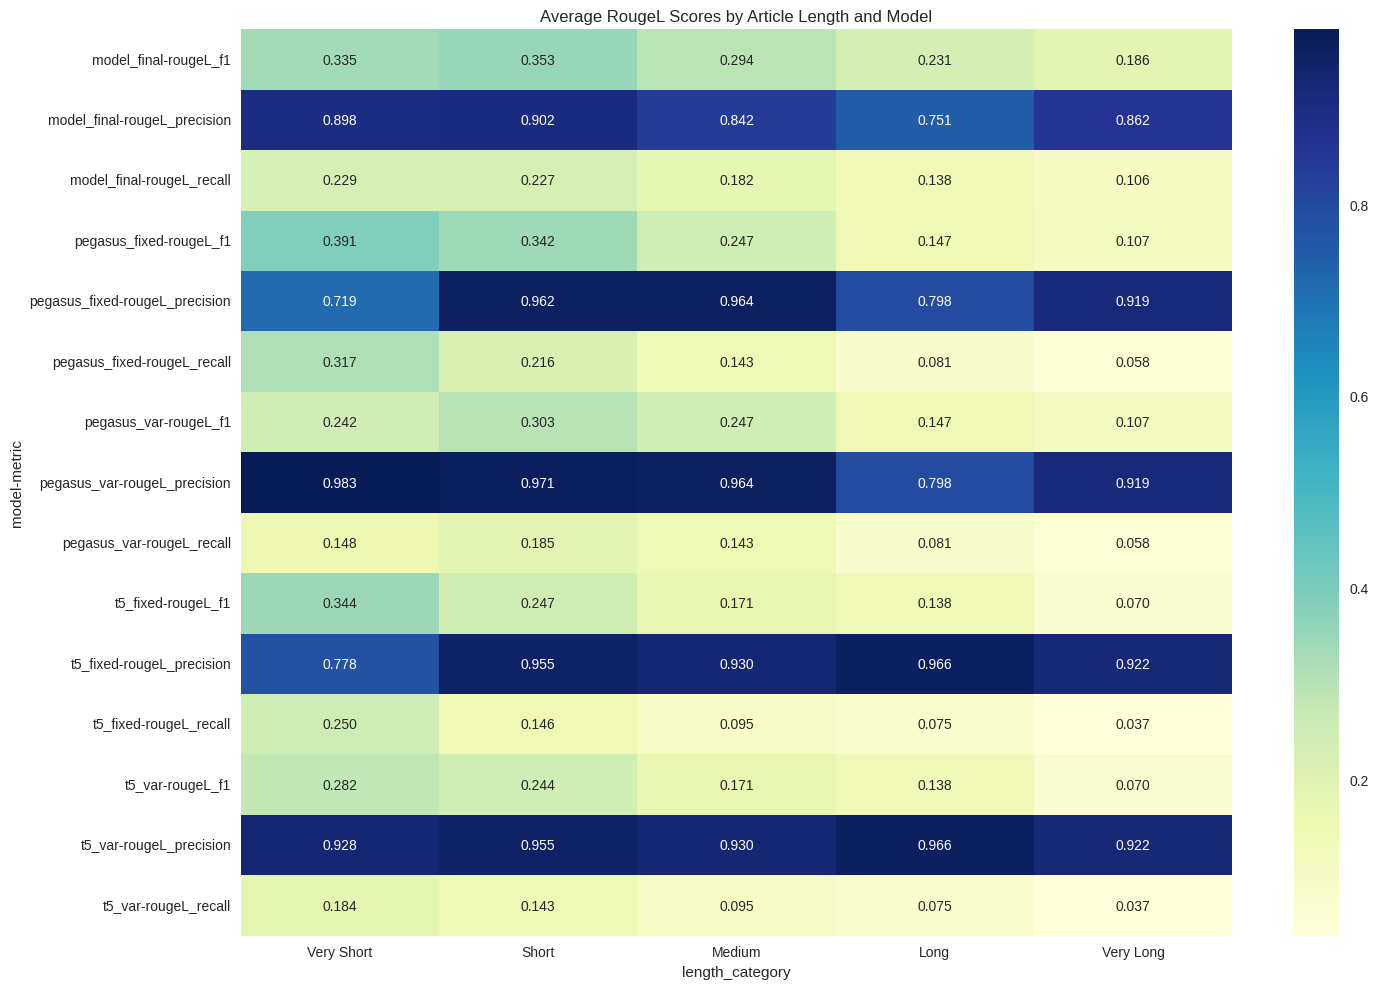

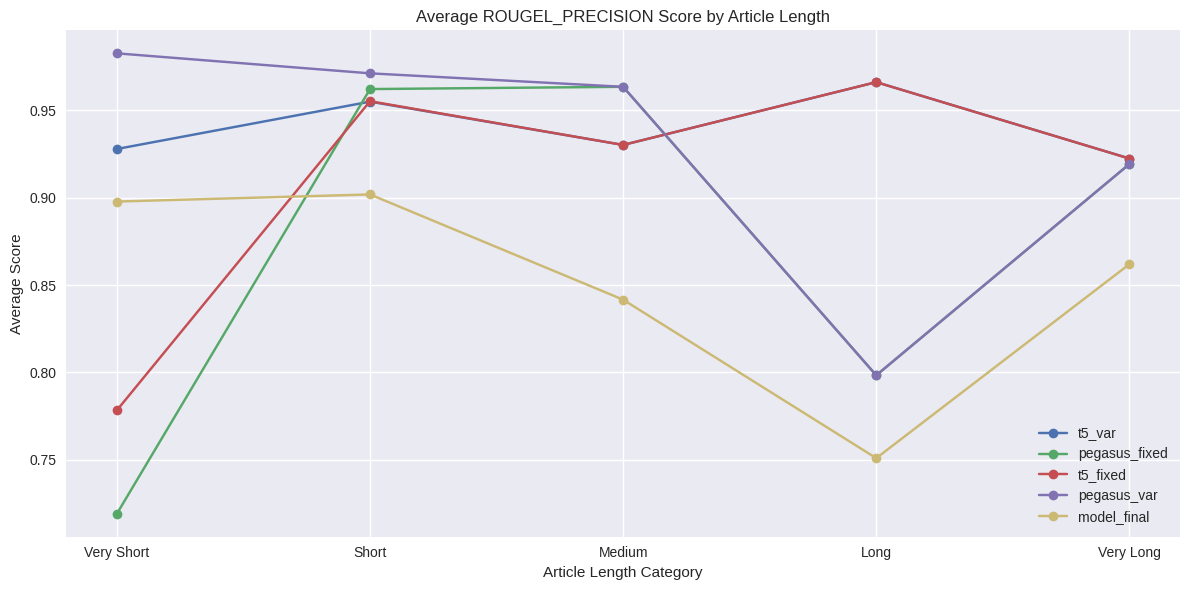

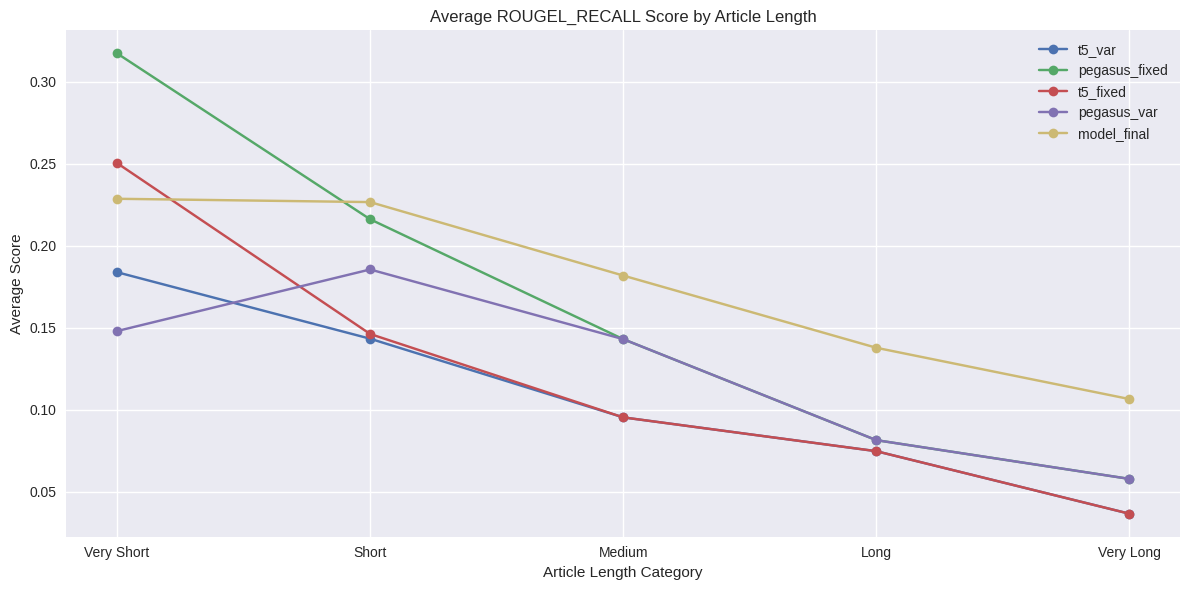

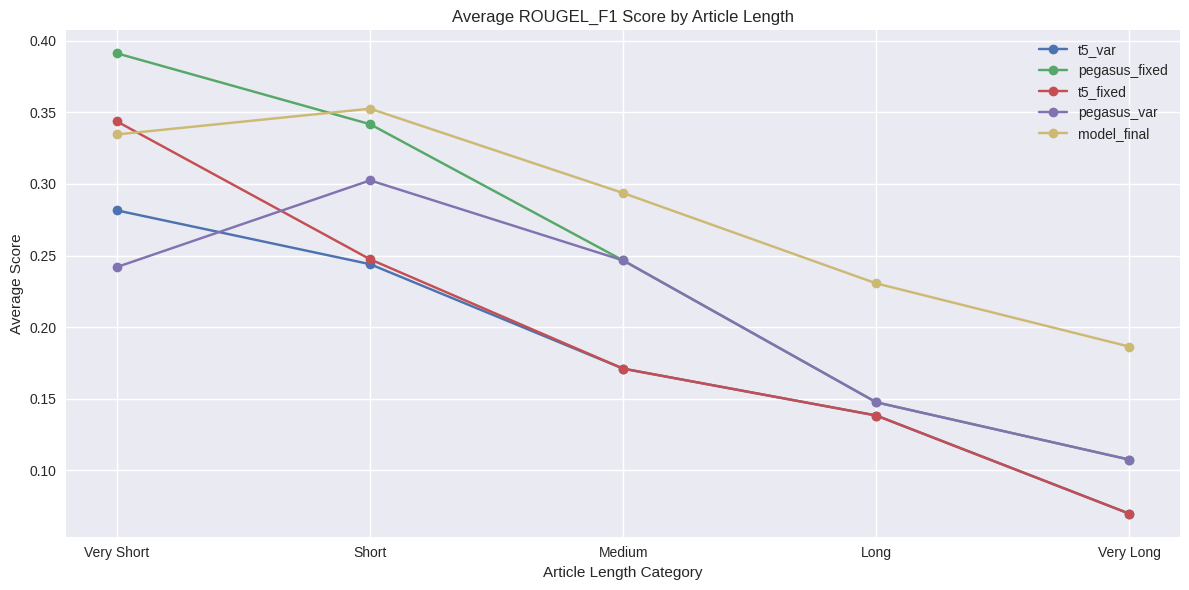

Average RougeL Scores by Article Length Category:
length_category                 Very Short     Short    Medium      Long  Very Long
model         metric                                                               
model_final   rougeL_f1           0.334633  0.352618  0.293656  0.230515   0.186311
              rougeL_precision    0.897807  0.901878  0.841601  0.750815   0.861928
              rougeL_recall       0.228567  0.226549  0.181749  0.137719   0.106446
pegasus_fixed rougeL_f1           0.391298  0.341763  0.246531  0.147395   0.107330
              rougeL_precision    0.719006  0.962248  0.963543  0.798280   0.919295
              rougeL_recall       0.317241  0.216078  0.142971  0.081390   0.057758
pegasus_var   rougeL_f1           0.241972  0.302522  0.246531  0.147395   0.107330
              rougeL_precision    0.982706  0.971258  0.963543  0.798280   0.919295
              rougeL_recall       0.147901  0.185460  0.142971  0.081390   0.057758
t5_fixed      rougeL_f1   

<ipython-input-63-4df1949684c6>:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate article lengths
df_merged['article_length'] = df_merged['input_text'].str.split().str.len()

# Define length categories
def categorize_length(length):
    if length < 200:
        return 'Very Short'
    elif length < 400:
        return 'Short'
    elif length < 600:
        return 'Medium'
    elif length < 800:
        return 'Long'
    else:
        return 'Very Long'

df_merged['length_category'] = df_merged['article_length'].apply(categorize_length)

# Define the order of length categories
length_order = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']

# Calculate average RougeL scores by length category and model
rougeL_metrics = ['rougeL_precision', 'rougeL_recall', 'rougeL_f1']
models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var', 'model_final']

avg_scores = []

for model in models:
    for metric in rougeL_metrics:
        for category in length_order:
            avg_score = df_merged[df_merged['length_category'] == category][f'{metric}_{model}'].mean()
            avg_scores.append({
                'model': model,
                'metric': metric,
                'length_category': category,
                'avg_score': avg_score
            })

avg_scores_df = pd.DataFrame(avg_scores)

# Ensure the length categories are in the correct order
avg_scores_df['length_category'] = pd.Categorical(avg_scores_df['length_category'], categories=length_order, ordered=True)
avg_scores_df = avg_scores_df.sort_values('length_category')

# Plot heatmap
plt.figure(figsize=(15, 10))
pivot_df = avg_scores_df.pivot_table(values='avg_score', index=['model', 'metric'], columns='length_category')
pivot_df = pivot_df.reindex(columns=length_order)
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Average RougeL Scores by Article Length and Model')
plt.tight_layout()
plt.show()

# Plot line graphs
for metric in rougeL_metrics:
    plt.figure(figsize=(12, 6))
    for model in models:
        data = avg_scores_df[(avg_scores_df['model'] == model) & (avg_scores_df['metric'] == metric)]
        plt.plot(data['length_category'], data['avg_score'], marker='o', label=model)

    plt.title(f'Average {metric.upper()} Score by Article Length')
    plt.xlabel('Article Length Category')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print summary statistics
print("Average RougeL Scores by Article Length Category:")
print(pivot_df.to_string())

# Analyze best model for each length category
best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]
best_models = best_models.sort_values(['metric', 'length_category'])
print("\nBest Performing Model by Length Category and RougeL Metric:")
print(best_models[['length_category', 'metric', 'model', 'avg_score']].to_string(index=False))

In [65]:
from google.colab import files
df_merged.to_csv('merged.csv')
files.download('merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_summary(summary):
    summary = re.sub(r'(\. )+\.', '.', summary)
    summary = re.sub(r'(\! )+\!', '!', summary)
    summary = re.sub(r'(\? )+\?', '?', summary)
    summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)
    return summary.strip()

def get_dynamic_length(input_token_count):
    if input_token_count < 200:  # Very Short
        max_length = min(int(input_token_count * 0.8), 160)
        min_length = max(int(input_token_count * 0.5), 50)
    elif input_token_count < 400:  # Short
        max_length = min(int(input_token_count * 0.7), 280)
        min_length = max(int(input_token_count * 0.4), 80)
    elif input_token_count < 600:  # Medium
        max_length = min(int(input_token_count * 0.6), 360)
        min_length = max(int(input_token_count * 0.3), 120)
    elif input_token_count < 800:  # Long
        max_length = min(int(input_token_count * 0.5), 400)
        min_length = max(int(input_token_count * 0.25), 150)
    else:  # Very Long
        max_length = min(int(input_token_count * 0.4), 500)
        min_length = max(int(input_token_count * 0.2), 200)

    min_length = min(min_length, max_length - 1)
    return max_length, min_length

def generate_summary(text):
    try:
        cleaned_text = clean_text(text)
        input_token_count = len(tokenizer.encode(cleaned_text))

        max_length, min_length = get_dynamic_length(input_token_count)

        max_input_length = 1024
        input_ids = tokenizer(cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids.to(device)

        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=min_length,
            length_penalty=1.5,
            num_beams=6,
            early_stopping=True,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
        )

        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_summary(summary)

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."

test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")